**ArSL Image Classification**

**1- Import needed libraries**<br>
**2- Load Data**<br>
**3- Define Functions**<br>
**4- Preparing Data**<br>
**5- Model Definition**<br>
**5.A- Model Definition**<br>
**5.B- Model Definition**<br>
**6- Model Training**<br>
**7- Model Evaluation**<br>
**8- Reports**<br>




**1- Import needed libraries**

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random # Generate pseudo-random numbers
from random import randint

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets
from sklearn.metrics import classification_report, confusion_matrix
import sklearn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # Specifies the geometry of the grid that a subplot can be placed in.

import keras
from keras import models as Models
from keras import layers as Layers
from keras.preprocessing import image
from keras.models import Sequential,Model
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import utils as Utils
from keras.utils import to_categorical # Converts a class vector (integers) to binary class matrix.

from keras.utils.vis_utils import model_to_dot

import seaborn as sns

In [ ]:
# global variables
Language = "Ar"
ImageClassMapping_path = "../input/Labels/ImagesClassPath.csv"
ClassLabels_path = "../input/Labels/ClassLabels.xlsx"
ImagesRoot_path = "../input/"

ModelFileName ='Model_255.h5'

**2- Load Data**


In [ ]:
# load 54k image path mapping
df_ImageClassPath = pd.read_csv(ImageClassMapping_path)
display(df_ImageClassPath.head())

,id,ClassId,ImagePath
0,1,0,ArASL_Database_54K/ain/AIN (1).JPG
1,2,0,ArASL_Database_54K/ain/AIN (10).JPG
2,3,0,ArASL_Database_54K/ain/AIN (100).jpg
3,4,0,ArASL_Database_54K/ain/AIN (1000).JPG
4,5,0,ArASL_Database_54K/ain/AIN (1001).JPG


In [ ]:
# load Class Labels
df_Classes = pd.read_excel(ClassLabels_path)
display(df_Classes.head())

,ClassId,Class,ClassAr
0,0,ain,عين
1,1,al,ال
2,2,aleff,الف
3,3,bb,باء
4,4,dal,دال


In [ ]:
df_ImageClassPath.groupby("ClassId").size().describe()

count      32.000000
mean     1689.031250
std       187.343825
min      1293.000000
25%      1589.500000
50%      1713.500000
75%      1797.250000
max      2114.000000
dtype: float64

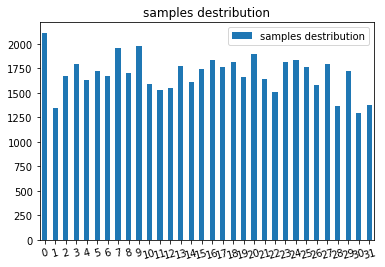

In [ ]:

ddata = {"samples destribution":df_ImageClassPath.groupby("ClassId").size()}
iindex = range(32)

ddataframe = pd.DataFrame(data=ddata, index= iindex)
ddataframe.plot.bar(stacked= True, rot= 15, title='samples destribution')
plt.show(block= True)

**3- Define Functions**

**SplitData(predictions,testsize):** *to split the data into Fixed number of samples for prediction(predictions) and rest will be splited by percentage of test and training (testsize)*<br><br>
**get_classlabel(class_code,lang= 'Ar'):** *to return Class Label for a class (class_code) in arabic of English , default is arabic*<br><br>
**getDataSet(setType,isDL):** *prepaer images and class to be used by model setType: Data type is training, validation or prediction, isDL: True for Keras CNN, False for skLearn KNN*<br><br>
**display_prediction(col_size, row_size,XPred,yPred):** *Generally to display images <br><br>

In [ ]:
# Split 54K Images into 3 groups of Fixed Prediction, training and test
# the dataset is 32 class,split is maintaind as per class 
def SplitData(predictions,testsize):
    
    min = df_ImageClassPath.groupby("ClassId").size().min()
    print('{0} Samples per Class'.format(min))
    
    # empty dataframes with same column difinition
    df_TrainingSet = df_ImageClassPath[0:0].copy()
    df_TestSet = df_ImageClassPath[0:0].copy()
    df_PredSet = df_ImageClassPath[0:0].copy()

    # Create the sets by loop thru classes and append
    for index,row in df_Classes.iterrows():
        # make sure all class are same size 
        df_FullSet = df_ImageClassPath[df_ImageClassPath['ClassId'] == row['ClassId']].sample(min,random_state= 42)
        
#         df_FullSet = df_ImageClassPath[df_ImageClassPath['ClassId'] == row['ClassId']]
        
        df_PredSet = df_PredSet.append(df_FullSet.sample(n=predictions, random_state=1))
        df_FullSet = pd.merge(df_FullSet,df_PredSet, indicator=True, 
                              how='left').query('_merge=="left_only"').drop('_merge', axis=1)
        
        trainingSet, testSet = train_test_split(df_FullSet, test_size= testsize)        
        
        df_TrainingSet = df_TrainingSet.append(trainingSet)
        df_TestSet = df_TestSet.append(testSet)
    
    return df_TrainingSet,df_TestSet,df_PredSet


In [ ]:
# retrive class Label (Arabic or English) using class id 
def get_classlabel(class_code,lang= 'Ar'):
    if lang== 'Ar':
        text_to_be_reshaped = df_Classes.loc[df_Classes['ClassId'] == class_code, 
                                             'ClassAr'].values[0]
        reshaped_text = arabic_reshaper.reshape(text_to_be_reshaped)
        return get_display(reshaped_text)
    elif lang== 'En':
        return df_Classes.loc[df_Classes['ClassId'] == class_code, 'Class'].values[0]
    

In [ ]:
# prepare Images, and class Arrays
def getDataSet(setType,isDL): # 'Training' for Training dataset , 'Testing' for Testing data set
    imgs = []
    lbls = []
    df = pd.DataFrame(None)
    
    if setType =='Training':
        df = dtTraining.copy()
    elif setType=='Test':
        df = dtTest.copy()
    elif setType=='Prediction':
        df = dtPred.copy()

    for index,row in df.iterrows():
        lbls.append(row['ClassId'])
        try:
            imageFilePath = os.path.join(ImagesRoot_path, row['ImagePath'])
            img = image.load_img(imageFilePath, target_size=(64,64,1), 
                                 color_mode = "grayscale")
            img = image.img_to_array(img) # to array
            img = img/255 # Normalize
            if isDL == False:
                img = img.flatten() # for knn_classifier Model
            imgs.append(img)

        except Exception as e:
            print(e)
            
    shuffle(imgs,lbls,random_state=255) #Shuffle the dataset

    imgs = np.array(imgs)
    lbls = np.array(lbls)
    if isDL ==True:
        lbls = to_categorical(lbls) # for keras CNN Model
    return imgs, lbls

In [ ]:
def display_prediction(col_size, row_size,XPred,yPred): 
    img_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(XPred[img_index][:,:,0], cmap='gray')
            ax[row][col].set_title("({}) {}".format(yPred[img_index],get_classlabel(yPred[img_index],'Ar')))
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
            img_index += 1

**4- Preparing Data**

In [ ]:
# Split our Dataset into Training, Test and Prediction
# take 3 images per class for later prediction (96 images 3 x 32 class category)
# split the remaining into 20% test and 80% Training

dtTraining, dtTest,dtPred = SplitData(3,0.3)

1293 Samples per Class


In [ ]:
print('Pred     {} \t # {} per class'.format(dtPred.shape[0], dtPred.shape[0] //32))
print('Training {} \t # {} per class'.format(dtTraining.shape[0], dtTraining.shape[0] //32))
print('Test     {} \t # {} per class'.format(dtTest.shape[0], dtTest.shape[0] //32))
print('---------------')
print('Sum      {}'.format(dtTraining.shape[0] + dtTest.shape[0] + dtPred.shape[0]))

Pred     96 	 # 3 per class
Training 28896 	 # 903 per class
Test     12384 	 # 387 per class
---------------
Sum      41376


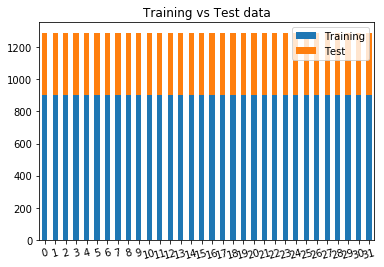

In [ ]:
ddata = {"Training":dtTraining.groupby("ClassId").size(),"Test":dtTest.groupby("ClassId").size()}
iindex = range(32)

ddataframe = pd.DataFrame(data=ddata, index= iindex)
ddataframe.plot.bar(stacked= True, rot= 15, title='Training vs Test data')
plt.show(block= True)

**5- Keras Convolutional Neural Network (CNN)**

In [ ]:
X_train,y_train = getDataSet('Training',True)
X_valid,y_valid = getDataSet('Test',True)
X_pred,_ = getDataSet('Prediction',True)

In [ ]:
print("Shape of Train Images:{} , Train Labels: {}".format(X_train.shape,y_train.shape))
print("Shape of Test Images:{} , Test Labels: {}".format(X_valid.shape,y_valid.shape))
print("Shape of Prediction Images:{} , Prediction Labels: {}".format(X_pred.shape,"?"))

Shape of Train Images:(28896, 64, 64, 1) , Train Labels: (28896, 32)
Shape of Test Images:(12384, 64, 64, 1) , Test Labels: (12384, 32)
Shape of Prediction Images:(96, 64, 64, 1) , Prediction Labels: ?


**8 couches**

In [ ]:
model = Models.Sequential()

model.add(Layers.Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(64,64,1)))
model.add(Layers.Conv2D(64, (3, 3), activation='relu'))
model.add(Layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Layers.Dropout(0.25))
model.add(Layers.Flatten())
model.add(Layers.Dense(128, activation='relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(32, activation='softmax'))




In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])



In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

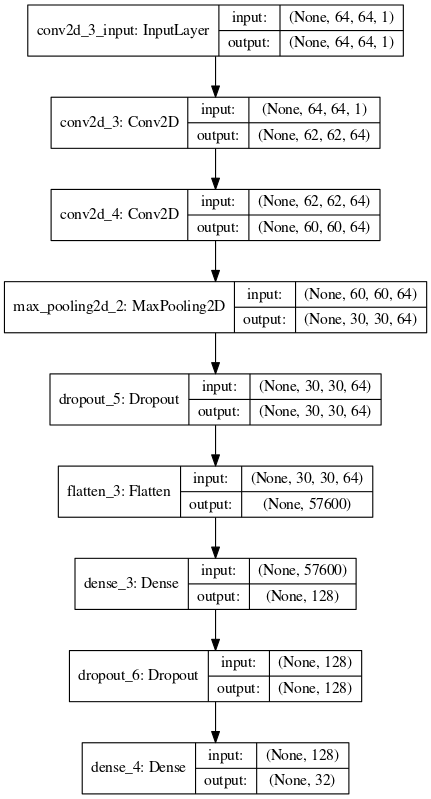

In [ ]:
Utils.plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True, dpi=80)

**6 couches**

In [ ]:
# model = Sequential(name='Predict')
model1 = Sequential(name='Predict')
model1.add(Layers.Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(64,64,1), name='conv2'))
model1.add(Layers.MaxPooling2D((2,2),name='maxPool1'))
model1.add(Layers.Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Layers.Dropout(0.2))
model1.add(Layers.Dense(32,activation = 'softmax',name='dns1'))

# model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])



In [ ]:
model1.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2 (Conv2D)               (None, 62, 62, 64)        640       
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               7872640   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dns1 (Dense)                 (None, 32)                4128      
Total params: 7,877,408
Trainable params: 7,877,408
Non-trainable params: 0
_________________________________________________

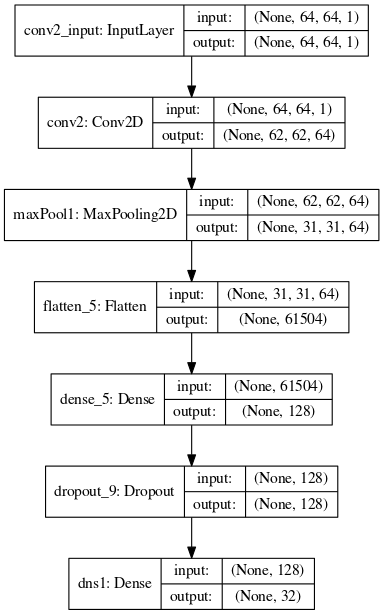

In [ ]:
Utils.plot_model(model1,to_file='model.png',show_shapes=True, show_layer_names=True, dpi=80)

**6- Model Training**

**8 couches**

In [ ]:
callbacks_list =[EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(
    filepath='model_255.h5', monitor='val_loss', save_best_only= True),]

trained = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid), 
                    callbacks= callbacks_list)


Train on 28896 samples, validate on 12384 samples
Epoch 1/15
28896/28896 [==============================] - 367s 13ms/step - loss: 1.9474 - accuracy: 0.4468 - val_loss: 0.6040 - val_accuracy: 0.8368
Epoch 2/15
28896/28896 [==============================] - 367s 13ms/step - loss: 0.7525 - accuracy: 0.7734 - val_loss: 0.3799 - val_accuracy: 0.9068
Epoch 3/15
28896/28896 [==============================] - 367s 13ms/step - loss: 0.5208 - accuracy: 0.8409 - val_loss: 0.3001 - val_accuracy: 0.9226
Epoch 4/15
28896/28896 [==============================] - 374s 13ms/step - loss: 0.4021 - accuracy: 0.8751 - val_loss: 0.2774 - val_accuracy: 0.9286
Epoch 5/15
28896/28896 [==============================] - 369s 13ms/step - loss: 0.3444 - accuracy: 0.8904 - val_loss: 0.2707 - val_accuracy: 0.9332
Epoch 6/15
28896/28896 [==============================] - 371s 13ms/step - loss: 0.2849 - accuracy: 0.9086 - val_loss: 0.2463 - val_accuracy: 0.9423
Epoch 7/15
28896/28896 [==============================] 

* <a href="./model_255.h5"> Download Model File </a>

**6 couches**

In [ ]:
callbacks_list1 =[EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(
    filepath='model1_255.h5', monitor='val_loss', save_best_only= True),]

trained1 = model1.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid), 
                    callbacks= callbacks_list1)

Train on 28896 samples, validate on 12384 samples
Epoch 1/15
28896/28896 [==============================] - 72s 2ms/step - loss: 2.7149 - accuracy: 0.2384 - val_loss: 1.3637 - val_accuracy: 0.6544
Epoch 2/15
28896/28896 [==============================] - 72s 2ms/step - loss: 1.1069 - accuracy: 0.6777 - val_loss: 0.7030 - val_accuracy: 0.8378
Epoch 3/15
28896/28896 [==============================] - 72s 2ms/step - loss: 0.6858 - accuracy: 0.8012 - val_loss: 0.4914 - val_accuracy: 0.8774
Epoch 4/15
28896/28896 [==============================] - 71s 2ms/step - loss: 0.4979 - accuracy: 0.8544 - val_loss: 0.4086 - val_accuracy: 0.9053
Epoch 5/15
28896/28896 [==============================] - 71s 2ms/step - loss: 0.3837 - accuracy: 0.8859 - val_loss: 0.3867 - val_accuracy: 0.9090
Epoch 6/15
28896/28896 [==============================] - 71s 2ms/step - loss: 0.3125 - accuracy: 0.9035 - val_loss: 0.3827 - val_accuracy: 0.9117
Epoch 7/15
28896/28896 [==============================] - 71s 2ms/st

* <a href="./model_255.h5"> Download Model File </a>

**7- Model Evaluation**

**8 couches**

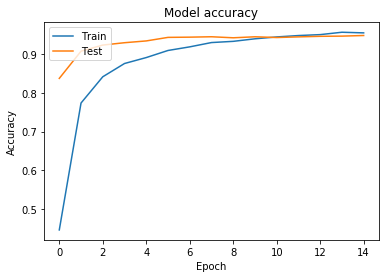

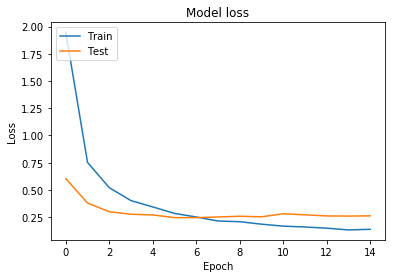

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**6 couches**

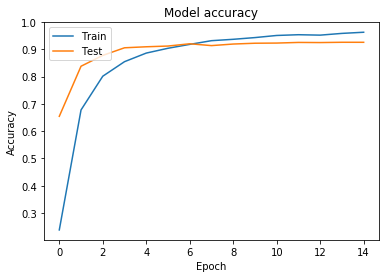

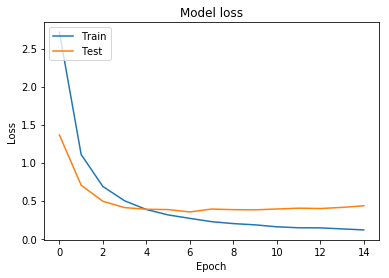

In [ ]:
plt.plot(trained1.history['accuracy'])
plt.plot(trained1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained1.history['loss'])
plt.plot(trained1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**8 couches**

In [ ]:
print("on Validation data")
pred1=model.evaluate(X_valid,y_valid)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))

on Validation data
12384/12384 [==============================] - 32s 3ms/step
accuaracy 94.71899271011353
Total loss 26.25011761692122


**6 couches**

In [ ]:
print("on Validation data")
pred1=model1.evaluate(X_valid,y_valid)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))

on Validation data
12384/12384 [==============================] - 7s 567us/step
accuaracy 92.53876209259033
Total loss 43.252044518746544


**8- Reports**

**8 couches**

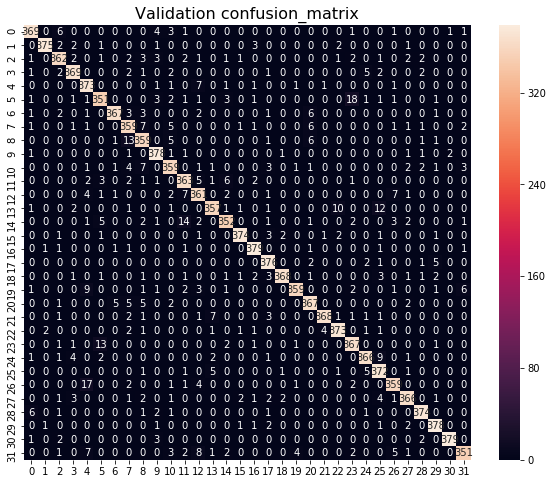

In [ ]:
from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10,8))
plt.title('Validation confusion_matrix', fontsize = 16) 
sns.heatmap(confusion_mtx, annot=True, fmt="d");


**6 couches**

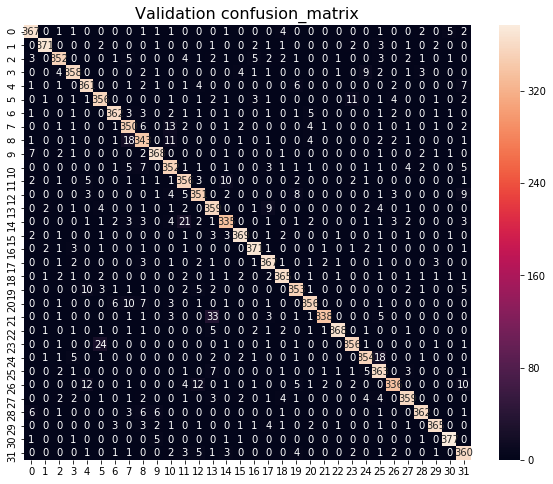

In [ ]:
from sklearn.metrics import confusion_matrix
Y_prediction1 = model1.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes1 = np.argmax(Y_prediction1,axis = 1) 
# Convert validation observations to one hot vectors
Y_true1 = np.argmax(y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx1 = confusion_matrix(Y_true1, Y_pred_classes1) 

plt.figure(figsize=(10,8))
plt.title('Validation confusion_matrix', fontsize = 16) 
sns.heatmap(confusion_mtx1, annot=True, fmt="d");
